# MATH 542 Project-2
### Aigerim Bazarkhanova

# Introduction

Every year car accidents cause the deaths of millions of people over the world, with a lot more injured people after the accidents. Kazakstan is not an exception in this situation. There are many factors that lead to accidents, which include driver condition (fatigue, intoxication), road conditions, weather conditions and a lot more. It is important to analyze these factors and to be able to reason about the causes of car accidents. In this work I have chosen to do exactly this by using the publicly available data on road accidents in Kazakhstan and  knowledge of machine learning techniques. 


I would not be that confident to claim the significance of findings, but I believe that the results of this work can give a better insight into the problem.

In this project I have followed the standard pipeline of data analysis routine. Firstly, I collected the data from the service that provides the information about car accidents in Kazakhstan during a selected range of time. Then, I preprocessed it using transformations I implemented specifically for this problem. Finally, I applied classification models (SoftMax, shallow and deep neural networks) and evaluated their performance using metric accuracy.





## Data collection

 I have following input features
 1. road condition
 2. road defects
 3. light conditions
 4. violation
 5. number of injured people
 6. number of dead people
 7. is the driver drunk
 8. causer of the accident
 9. is public transport
 10. is weekday
 11. is winter
 
 
Target feature -  type of the Road traffic accident


0: Car accident (Автомобильная авария) 

1: Collision with a pedestrian (Столкновение с пешеходом) 

2: Other RTA (Другое ДТП)



In [1]:
import json
import requests


In [2]:
url = "http://infopublic.pravstat.kz:8399/arcgis/rest/services/rta/MapServer/0/query"

In [3]:
params = {
    "f": "json",
    "where": "RTA_DATE>= TIMESTAMP '2010-01-01 00:00:00' AND RTA_DATE<= TIMESTAMP '2019-11-20 23:59:59'",
    "returnGeometry": "true",
    "spatialRel": "esriSpatialRelIntersects",
    "geometry": "{'xmin':3368705.1410122006,'ymin':4094299.6672902238,'xmax':12433525.199405413,'ymax':8203554.307900207,'spatialReference':{'wkid':102100,'latestWkid':3857}}",
    "geometryType": "esriGeometryEnvelope",
    "inSR": 102100,
    "outFields": "RTA_TYPE,RTA_DATE,FD1R01P1,FD1R07P2,FD1R071P1,FD1R09P1,FD1R14P1,FD1R141P1,FD1R13P1,FD1R13P2,IS_PUBLIC_TRANSPORT",
    "outSR": 102100
}

Executing this takes about a minute or two (response size is about 50 MB).

In [4]:
response = requests.get(url, params=params)

In [5]:
json_data = response.json()

In [6]:
print(f"Type of response object: {type(json_data)}")

Type of response object: <class 'dict'>


In [7]:
# inspecting the keys of json_data dictionary
print(f"Keys of object: {json_data.keys()}")

Keys of object: dict_keys(['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features', 'exceededTransferLimit'])


In [8]:
# inspecting the keys of json_data dictionary
print(f"Keys of object: {json_data.keys()}")

Keys of object: dict_keys(['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features', 'exceededTransferLimit'])


In [9]:

# show keys
print(f"displayFieldName: {json_data['displayFieldName']}")
print(f"fieldAliases: {json_data['fieldAliases']}")
print(f"geometryType: {json_data['geometryType']}")
print(f"spatialReference: {json_data['spatialReference']}")
print(f"fields: {json_data['fields']}")

displayFieldName: RTA_TYPE
fieldAliases: {'RTA_TYPE': 'Тип', 'RTA_DATE': 'Дата', 'FD1R01P1': 'FD1R01P1', 'FD1R07P2': 'FD1R07P2', 'FD1R071P1': 'FD1R071P1', 'FD1R09P1': 'FD1R09P1', 'FD1R14P1': 'FD1R14P1', 'FD1R141P1': 'FD1R141P1', 'FD1R13P1': 'FD1R13P1', 'FD1R13P2': 'FD1R13P2', 'IS_PUBLIC_TRANSPORT': 'IS_PUBLIC_TRANSPORT'}
geometryType: esriGeometryPoint
spatialReference: {'wkid': 102100, 'latestWkid': 3857}
fields: [{'name': 'RTA_TYPE', 'type': 'esriFieldTypeSmallInteger', 'alias': 'Тип'}, {'name': 'RTA_DATE', 'type': 'esriFieldTypeDate', 'alias': 'Дата', 'length': 36}, {'name': 'FD1R01P1', 'type': 'esriFieldTypeString', 'alias': 'FD1R01P1', 'length': 1073741822}, {'name': 'FD1R07P2', 'type': 'esriFieldTypeString', 'alias': 'FD1R07P2', 'length': 200}, {'name': 'FD1R071P1', 'type': 'esriFieldTypeString', 'alias': 'FD1R071P1', 'length': 1073741822}, {'name': 'FD1R09P1', 'type': 'esriFieldTypeString', 'alias': 'FD1R09P1', 'length': 1073741822}, {'name': 'FD1R14P1', 'type': 'esriFieldTypeSt

In [10]:
print(f"Number of data points: {len(json_data['features'])}")

Number of data points: 50000


In [11]:
# mapping properties of data to proper format
attribute_mapping = {
    'FD1R01P1': 'road_condition', # состояние дорожного покрытия
    'FD1R071P1': 'road_defects', # наличие дефектов уличной сети
    'FD1R07P2': 'light_conditions', # освещенность
    'FD1R09P1': 'violation', # нарушение
    'FD1R13P1': 'injured_num', # кол-во раненных
    'FD1R13P2': 'dead_num', # кол-во погибших
    'FD1R141P1': 'is_drunk', # состояние виновного (трезвый, в алкогольном опъянении)
    'FD1R14P1': 'causer', # виновный (имеющий права, пешеход, скрывшийся с места преступления)
    'IS_PUBLIC_TRANSPORT': 'is_public_transport',
    'RTA_DATE': 'date', # дата ДТП
    'RTA_TYPE': 'type' # тип ДТП (узнать различные типы)
}

Note: for the type feature, we know that 0 is a car collision accident, 1 is a collision with pedestrian and 2 is some other type.


## Transforming features

In [12]:
# copy library for copying dictionaries
import copy
# processing date
import datetime
# preprocessing categorical data
from sklearn.preprocessing import LabelEncoder

In [13]:
class Transformer:
  def __init__(self, verbose=False):
    self.transforms = []
    self.verbose = verbose
    
  def add_transform(self, name, function):
    self.transforms.append((name, function))
    
  def apply(self, data):
    # create an empty array for storing transformed data
    transformed_data = []
    # iterate over each data point
    for i, data_point in enumerate(data):
      if self.verbose:
        print(f"Data point: {i}")
      
      # copy of the object
      transformed_data_point = copy.deepcopy(data_point)
      # iterate over each transform
      for transform in self.transforms:
        transform[1](transformed_data_point)
      # add transformed data point to array
      transformed_data.append(transformed_data_point)
      
    return transformed_data

In [14]:

def transform_attribute_names(data_point):
  # iterate through list of attributes
  for attribute in attribute_mapping.keys():
    # create a new attribute
    data_point[attribute_mapping[attribute]] = data_point['attributes'][attribute]
    # delete old attribute
    del data_point['attributes'][attribute]
  # remove attributes field
  del data_point['attributes']
  # add geometry attributes
  data_point['x'] = data_point['geometry']['x']
  data_point['y'] = data_point['geometry']['y']
  # delete geomtry field
  del data_point['geometry']

In [15]:

def transform_date(data_point):
  # get weekday from epoch timestamp
  weekday = datetime.datetime.fromtimestamp(data_point['date']/1000).weekday()
  # create is_weekday attribute
  data_point['is_weekday'] = 0 if weekday == 5 or weekday == 6 else 1
  # get month from epoch timestamp
  month = datetime.datetime.fromtimestamp(data_point['date']/1000).month
  # create is_winter attribute
  data_point['is_winter'] = 1 if month == 11 or month == 12 or month == 1 or month == 2 else 0
  # delete date field
  del data_point['date']

In [16]:
def transform_none_values(data_point):
  # transform injured_num None to 0
  if data_point['injured_num'] is None:
    data_point['injured_num'] = 0
  # transform dead_num None to 0
  if data_point['dead_num'] is None:
    data_point['dead_num'] = 0
  # transform road_condition None to "неизвестно"
  if data_point['road_condition'] is None:
    data_point['road_condition'] = 'неизвестно'
  # transform road_defects None to "неизвестно"
  if data_point['road_defects'] is None:
    data_point['road_defects'] = 'неизвестно'
  # transform light_conditions None to "неизвестно"
  if data_point['light_conditions'] is None:
    data_point['light_conditions'] = 'неизвестно'
  # transform is_drunk None to "неизвестно"
  if data_point['is_drunk'] is None:
    data_point['is_drunk'] = 'неизвестно'
  # transform violation None to "неизвестно"
  if data_point['violation'] is None:
    data_point['violation'] = 'неизвестно'
  # transform causer None to "неизвестно"
  if data_point['causer'] is None:
    data_point['causer'] = 'неизвестно'

In [17]:

def transform_with_trimming(data_point):
  # trim road_condition field
  data_point['road_condition'] = data_point['road_condition'].strip()
  # trim road_defects field
  data_point['road_defects'] = data_point['road_defects'].strip()
  # trim violation field
  data_point['violation'] = data_point['violation'].strip()
  # trim causer field
  data_point['causer'] = data_point['causer'].strip()

In [18]:
def transform_rare_values(data_point):
  # transform road_condition values
  road_condition_values = ['сухая', 'мокрая', 'обледеневшая', 'заснеженная']
  if data_point['road_condition'] not in road_condition_values:
    data_point['road_condition'] = 'неизвестно'

In [19]:
def transform_by_removing(data_point):
  # remove road condition field
  # del data_point['road_condition']
  # remove x
  del data_point['x']
  # remove y
  del data_point['y']

In [20]:
# create new Transformed object
transformer = Transformer()

In [21]:
# add transforms
transformer.add_transform("transform_attribute_names", transform_attribute_names)
transformer.add_transform("transform_date", transform_date)
transformer.add_transform("transform_none_values", transform_none_values)
transformer.add_transform("transform_with_trimming", transform_with_trimming)
transformer.add_transform("transform_rare_values", transform_rare_values)
transformer.add_transform("transform_by_removing", transform_by_removing)

In [22]:
# apply transform to our data
transformed_data = transformer.apply(json_data['features'])

In [23]:
# apply lambda and filter function
transformed_data = list(filter(lambda x: x['type'] != 2, transformed_data))
print(f"New number of data points: {len(transformed_data)}")

New number of data points: 46417


In [24]:
def get_unique_values_for_attribute(attribute, data):
  # create map for storing unique values
  unique = {}
  # iterate through all data looking at specific attribute
  for accident in data:
    # add value to unique values array if it is not there already
    if accident[attribute] not in unique.keys():
      unique[accident[attribute]] = 1
    else:
      unique[accident[attribute]] += 1
      
  return unique

In [25]:
for attribute in transformed_data[0].keys():
  print(f"Attribute: {attribute}")
  print(f"Unique values: {get_unique_values_for_attribute(attribute, transformed_data)}")

Attribute: road_condition
Unique values: {'сухая': 24799, 'мокрая': 3997, 'обледеневшая': 1142, 'заснеженная': 1673, 'неизвестно': 14806}
Attribute: road_defects
Unique values: {'отсутствуют': 33122, 'неровное покрытие': 143, 'скользкое покрытие; выбоины': 3, 'скользкое покрытие': 1326, 'иные условия': 9566, 'пешеходных дорожек': 76, 'неизвестно': 1531, 'неровное покрытие; иные условия': 7, 'коллейность; выбоины': 4, 'отсутствие дорожной разметки или плохая ее видимость': 142, 'коллейность; выбоины; иные условия': 4, 'выбоины': 70, 'недостаточное освещение проезжей части': 125, 'коллейность': 40, 'неровное покрытие; коллейность; выбоины; неудовлетворительное состояние обочины': 2, 'скользкое покрытие; неровное покрытие': 8, 'отсутствие дорожной разметки или плохая ее видимость; иные условия': 7, 'пешеходных дорожек; иные условия': 5, 'неровное покрытие; отсутствие тротуаров': 1, 'скользкое покрытие; иные условия': 18, 'неровное покрытие; выбоины': 6, 'отсутствие тротуаров; пешеходных д

Let's create LabelEncoder's for different categorical attributes because I have to somehow represent them with numbers. For that, I use sklearn LabelEncoder class, which converts categorical variables into numbers.

In [26]:
# create a list of label encoders
label_encoders = []

road_condition_le = LabelEncoder()
road_condition_le.fit(list(get_unique_values_for_attribute("road_condition", transformed_data).keys()))
label_encoders.append(road_condition_le)
print(f"road condition classes: {list(road_condition_le.classes_)}")

road_defects_le = LabelEncoder()
road_defects_le.fit(list(get_unique_values_for_attribute("road_defects", transformed_data).keys()))
label_encoders.append(road_defects_le)
print(f"road defects classes: {list(road_defects_le.classes_)}")

light_conditions_le = LabelEncoder()
light_conditions_le.fit(list(get_unique_values_for_attribute("light_conditions", transformed_data).keys()))
label_encoders.append(light_conditions_le)
print(f"light conditions classes: {list(light_conditions_le.classes_)}")

violation_le = LabelEncoder()
violation_le.fit(list(get_unique_values_for_attribute("violation", transformed_data).keys()))
label_encoders.append(violation_le)
print(f"violation classes: {list(violation_le.classes_)}")

is_drunk_le = LabelEncoder()
is_drunk_le.fit(list(get_unique_values_for_attribute("is_drunk", transformed_data).keys()))
label_encoders.append(is_drunk_le)
print(f"is_drunk classes: {list(is_drunk_le.classes_)}")

causer_le = LabelEncoder()
causer_le.fit(list(get_unique_values_for_attribute("causer", transformed_data).keys()))
label_encoders.append(causer_le)
print(f"causer classes: {list(causer_le.classes_)}")

road condition classes: ['заснеженная', 'мокрая', 'неизвестно', 'обледеневшая', 'сухая']
road defects classes: ['выбоины', 'выбоины; отсутствие дорожной разметки или плохая ее видимость', 'деревья', 'иные условия', 'коллейность', 'коллейность; выбоины', 'коллейность; выбоины; иные условия', 'коллейность; выбоины; неудовлетворительное состояние обочины', 'коллейность; несоответсвие габарита путепровода ширине дороги', 'коллейность; опоры светильников (в случаях наезда, ограничения видимости)', 'недостаточное освещение проезжей части', 'недостаточное освещение проезжей части; иные условия', 'неизвестно', 'неисправность тсодд или плохая их видимость', 'неисправность тсодд или плохая их видимость; отсутствие дорожной разметки или плохая ее видимость', 'неровное покрытие', 'неровное покрытие; выбоины', 'неровное покрытие; выбоины; иные условия', 'неровное покрытие; выбоины; недостаточное освещение проезжей части', 'неровное покрытие; выбоины; недостаточное освещение проезжей части; отсутств

In [27]:
for i, data_point in enumerate(transformed_data):
  for j, categorical_feature in enumerate(["road_condition", "road_defects", "light_conditions", "violation", "is_drunk", "causer"]):
    data_point[categorical_feature] = label_encoders[j].transform([data_point[categorical_feature]])[0]

## Converting JSON array to dataframe

In [28]:
# importing pandas to create dataframe
import pandas as pd

In [29]:
 # initialize an empty list for data
data = []
# create a list of all features
features = list(transformed_data[0].keys())
# move "type" to the end of the list
features.remove("type")
features.append("type")
# iterate over each data point and add to list
for data_point in transformed_data:
  # create a list for data point
  df_item = []
  # iterate over all features
  for feature in features:
    df_item.append(data_point[feature])
  # add data point list to list of all data
  data.append(df_item)
  
# create the pandas DataFrame 
da = pd.DataFrame(data, columns=features) 
  
# print dataframe
da

,road_condition,road_defects,light_conditions,violation,injured_num,dead_num,is_drunk,causer,is_public_transport,is_weekday,is_winter,type
0,4,62,0,36,8,0,6,2,1,1,0,0
1,1,15,0,82,1,0,6,2,0,1,0,0
2,3,62,0,11,1,0,6,26,0,1,0,1
3,0,62,3,82,0,2,6,2,0,1,1,1
4,4,62,2,15,1,0,6,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
46412,4,62,0,62,1,0,6,2,0,0,0,0
46413,4,62,0,15,1,0,3,29,0,1,1,0
46414,4,62,0,82,1,0,6,2,0,0,0,0
46415,4,62,0,15,1,0,3,29,0,1,0,1


Now this looks more or less properly, compared to the initial format of the data. 

In [30]:
import numpy as np

In [31]:
X = da.loc[:, ['road_condition', 'road_defects', 'light_conditions',	
                 'violation', 'injured_num', 'dead_num', 'is_drunk',	'is_winter', 'is_weekday',	
                 'is_public_transport', 'causer']].values.copy()
y = da.loc[:, 'type'].values.copy()

In [32]:
for i, rta in enumerate(y):
    if rta == 0:
        y[i] = 0
    elif rta == 1:
        y[i] = 1
    else:
        y[i] = 2
        
        

In [33]:
# generate random indices
idx = np.random.randint(0, X.shape[0], size=10000)

X = X[idx,:]
y = y[idx]

In [34]:
y = y.astype(np.int32)

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

In [37]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
from torch import nn
import torch
import pandas as pd
import numpy as np
from torch import nn,optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable




In [38]:
class Data_train(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.tensor(X_train).type(torch.FloatTensor)
        self.y = torch.tensor(y_train).type(torch.LongTensor)
        
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

In [39]:
class Data_val(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.tensor(X_val).type(torch.FloatTensor)
        self.y = torch.tensor(y_val).type(torch.LongTensor)
        
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

In [40]:
class Data_test(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.tensor(X_test).type(torch.FloatTensor)
        self.y = torch.tensor(y_test).type(torch.LongTensor)
        
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

In [41]:
dataset = Data_train()
data_set = Data_val()
data__set = Data_test()

In [42]:
def train(model, criterion, trainloader, data_set, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss': [], 'validation_loss': []}  
    
    for epoch in range(epochs):
        model.train()
        for i, (x, y) in enumerate(trainloader):
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
        useful_stuff['training_loss'].append(loss.data.item())
        model.eval()
        useful_stuff['validation_loss'].append(criterion(model(data_set.x), data_set.y).item())
    
    return useful_stuff

## MODEL 1

In [43]:
class SoftMax(torch.nn.Module):
    def __init__(self, input_size, output_size, p = 0):
        super(SoftMax,self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
    def forward(self, x):
        z = self.linear(x)
        return z

In [44]:
lr = 0.001
epochs = 1000
batch_size = 1000
trainloader = DataLoader(dataset = dataset, batch_size = batch_size)



In [45]:
model_1 = SoftMax(11, 3)

In [46]:
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr = lr)

In [47]:
criterion= torch.nn.CrossEntropyLoss()

In [48]:
results_1 = train(model_1, criterion = criterion, trainloader = trainloader, data_set = data_set, 
                 optimizer = optimizer_1, epochs = epochs)

In [49]:
results_1

{'training_loss': [13.487553596496582,
  12.686025619506836,
  11.88044261932373,
  11.07150650024414,
  10.261789321899414,
  9.4528226852417,
  8.651293754577637,
  7.876247406005859,
  7.160078048706055,
  6.517120361328125,
  5.933245658874512,
  5.390211582183838,
  4.8746337890625,
  4.3818888664245605,
  3.92838191986084,
  3.5547780990600586,
  3.2670035362243652,
  3.030898332595825,
  2.8180031776428223,
  2.616729974746704,
  2.4247217178344727,
  2.2415289878845215,
  2.06691575050354,
  1.9011445045471191,
  1.7449523210525513,
  1.5995113849639893,
  1.466284155845642,
  1.3466652631759644,
  1.241603136062622,
  1.1514161825180054,
  1.0757248401641846,
  1.0135265588760376,
  0.963331937789917,
  0.9233365654945374,
  0.891626238822937,
  0.8663827180862427,
  0.8460246324539185,
  0.8292866945266724,
  0.8151968717575073,
  0.8030430674552917,
  0.7923104763031006,
  0.782630205154419,
  0.7737382054328918,
  0.7654463052749634,
  0.7576175332069397,
  0.75015264749526

In [50]:
def acc_score(model, data):
  _, y_pred = torch.max(model(data__set.x), 1)
  return (y_pred == data__set.y).numpy().mean()


In [51]:
acc_score(model = model_1, data = data__set)

0.778

In [69]:
def plot_accuracy_loss(results): 
    plt.subplot(2, 1, 1)
    plt.plot(results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(results['validation_loss'])
    plt.ylabel('loss')
    plt.xlabel('validation loss iterations')
    plt.show()


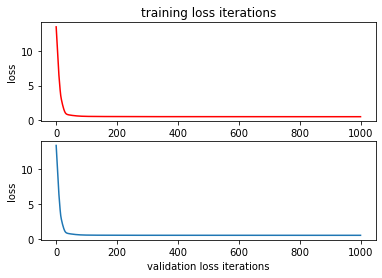

In [70]:
plot_accuracy_loss(results=results_1)

## MODEL 2

In [54]:
class Net(nn.Module):
  def __init__(self,D_in, H, D_out):
    super(Net, self).__init__()
    self.linear1 = nn.Linear(D_in, H)
    self.linear2 = nn.Linear(H, D_out)

  def forward(self, x):
    x = torch.relu(self.linear1(x))
    x = torch.relu(self.linear2(x))
    return x  

In [55]:
model_2 = Net(11,3,3)

In [56]:
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr = lr)

In [57]:
results_2 = train(model_2, criterion = criterion, trainloader = trainloader, data_set = data_set, 
                 optimizer = optimizer_2, epochs = epochs)

In [58]:
results_2

{'training_loss': [1.2104543447494507,
  1.1918222904205322,
  1.177492618560791,
  1.1639248132705688,
  1.1546435356140137,
  1.1458518505096436,
  1.1359405517578125,
  1.128947377204895,
  1.1242027282714844,
  1.1206177473068237,
  1.1179126501083374,
  1.1146397590637207,
  1.1105238199234009,
  1.1098214387893677,
  1.1095571517944336,
  1.1092525720596313,
  1.1087877750396729,
  1.1078228950500488,
  1.1058745384216309,
  1.1030961275100708,
  1.1006147861480713,
  1.099626064300537,
  1.0992088317871094,
  1.0990571975708008,
  1.0989933013916016,
  1.098957896232605,
  1.098934292793274,
  1.0989160537719727,
  1.0989004373550415,
  1.0988861322402954,
  1.098872423171997,
  1.0988599061965942,
  1.0988481044769287,
  1.0988373756408691,
  1.0988271236419678,
  1.0988171100616455,
  1.0988073348999023,
  1.0987977981567383,
  1.0987883806228638,
  1.0987803936004639,
  1.0987757444381714,
  1.0987716913223267,
  1.098767876625061,
  1.0987643003463745,
  1.0987604856491089,


In [59]:
acc_score(model = model_2, data= data__set)

0.524

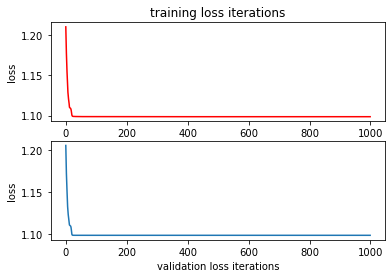

In [71]:
plot_accuracy_loss(results = results_2)

## MODEL 3

In [61]:
class DeepNN(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(DeepNN, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.relu(linear_transform(activation))
            else:
                activation = linear_transform(activation)
        return activation

In [62]:
Layers = [11, 10, 10, 3]
model_3 = DeepNN(Layers)

In [63]:

optimizer_3 = torch.optim.Adam(model_3.parameters(), lr = lr)

In [64]:
criterion= torch.nn.CrossEntropyLoss()

In [65]:
results_3 = train(model_3, criterion = criterion, trainloader = trainloader, data_set = data_set, 
                 optimizer = optimizer_3, epochs = epochs)

In [66]:
results_3

{'training_loss': [2.1122007369995117,
  1.6850320100784302,
  1.4099373817443848,
  1.2255290746688843,
  1.096323847770691,
  1.0008424520492554,
  0.9250525832176208,
  0.8636547923088074,
  0.8148618340492249,
  0.775094211101532,
  0.7419612407684326,
  0.7147735357284546,
  0.6918413043022156,
  0.6751645803451538,
  0.6644014716148376,
  0.6567415595054626,
  0.6504815816879272,
  0.644974410533905,
  0.6399595737457275,
  0.6355593800544739,
  0.631731390953064,
  0.6281275749206543,
  0.6246848702430725,
  0.62144535779953,
  0.618304431438446,
  0.6152898073196411,
  0.6124038696289062,
  0.6095965504646301,
  0.6069039702415466,
  0.6042904257774353,
  0.6017220616340637,
  0.5992441177368164,
  0.5968233346939087,
  0.5945715308189392,
  0.5922874808311462,
  0.5901855230331421,
  0.588047444820404,
  0.5860328078269958,
  0.584077775478363,
  0.5821762681007385,
  0.5803631544113159,
  0.5785950422286987,
  0.5768662095069885,
  0.575192928314209,
  0.5735451579093933,
  0

In [67]:
acc_score(model = model_3, data = data__set)

0.8

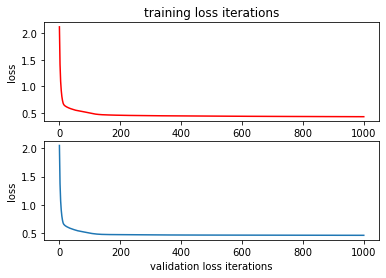

In [72]:
plot_accuracy_loss(results = results_3)

# Conclusion

Taking into account results of accuracy score of 3 models, it can be concluded that the best performance has shown by Deep NN(due to the number of hidden layers). Nevertheless, I think that modeling still needs improvement to show accuracy around 90.

Model | Accuracy Score | |
--- | --- | --- 
Softmax   |0.778
Shallow Neural Networks |0.524
Deep Neural Networks |  0.80|